In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
nadf = pd.DataFrame(pd.read_csv('./thermal_data_none.csv'))
nadf.head()
frames_none = nadf.iloc[:,3:67]
# frames_none = frames_none*255/100
frames_none.shape

In [ ]:
hudf = pd.DataFrame(pd.read_csv('./thermal_data_human_one.csv'))
hudf.head()
frames_hu = hudf.iloc[:,3:67]
# frames_hu = frames_hu*255/100
frames_hu.shape

온도 데이터 전체 범위: 20.50°C ~ 29.00°C
------------------------------
배경 프레임 수: 4073
열원 포함 프레임 수: 2000
------------------------------
--- 배경 프레임으로 배경 모델 학습 시작 ---
  500/4073 프레임 학습 완료...
  1000/4073 프레임 학습 완료...
  1500/4073 프레임 학습 완료...
  2000/4073 프레임 학습 완료...
  2500/4073 프레임 학습 완료...
  3000/4073 프레임 학습 완료...
  3500/4073 프레임 학습 완료...
  4000/4073 프레임 학습 완료...
--- 배경 모델 학습 완료 ---
------------------------------
--- 열원 포함 프레임 처리 시작 ---
  200/2000 프레임 처리 완료...
  400/2000 프레임 처리 완료...
  600/2000 프레임 처리 완료...
  800/2000 프레임 처리 완료...
  1000/2000 프레임 처리 완료...
  1200/2000 프레임 처리 완료...
  1400/2000 프레임 처리 완료...
  1600/2000 프레임 처리 완료...
  1800/2000 프레임 처리 완료...
  2000/2000 프레임 처리 완료...
--- 열원 포함 프레임 처리 완료 ---
------------------------------


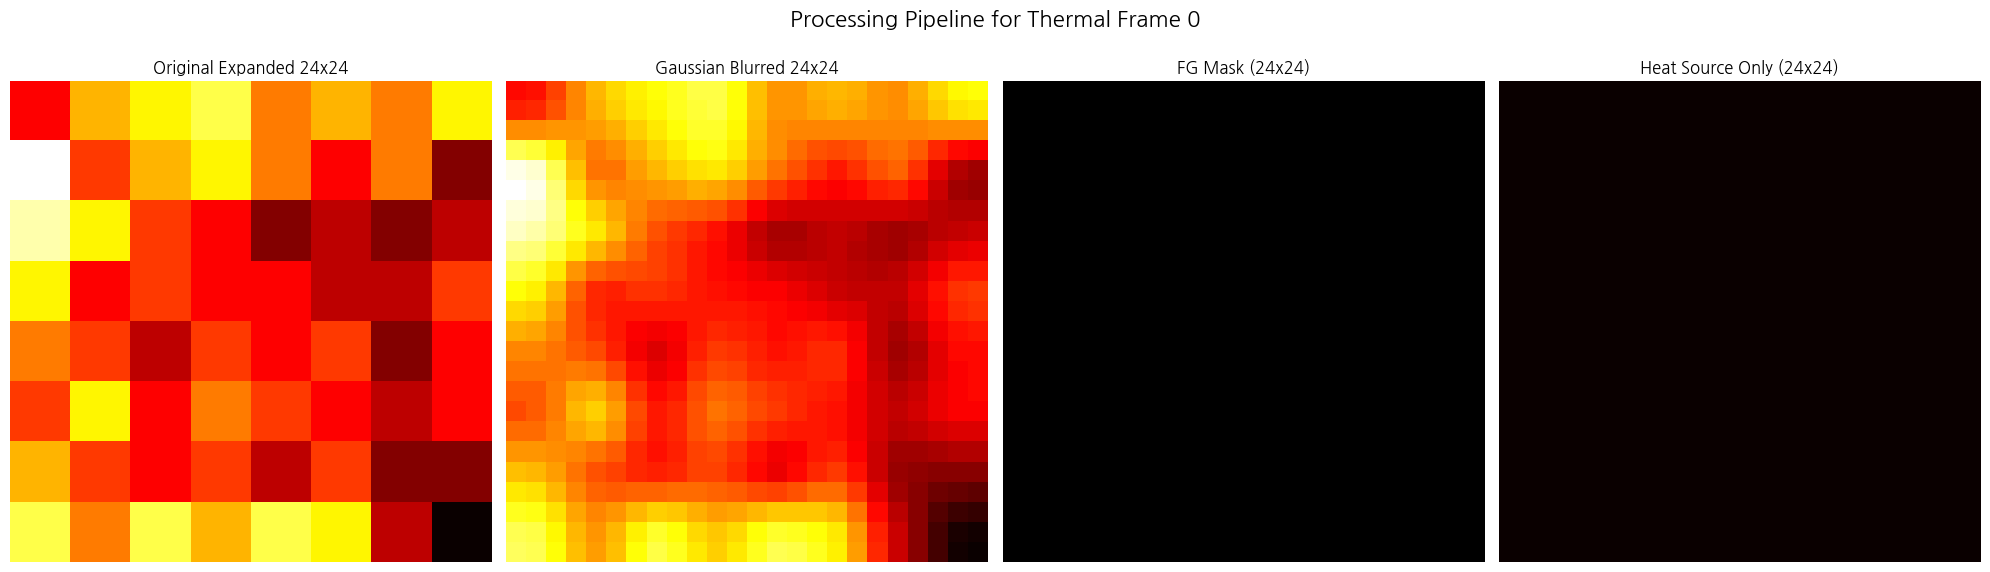

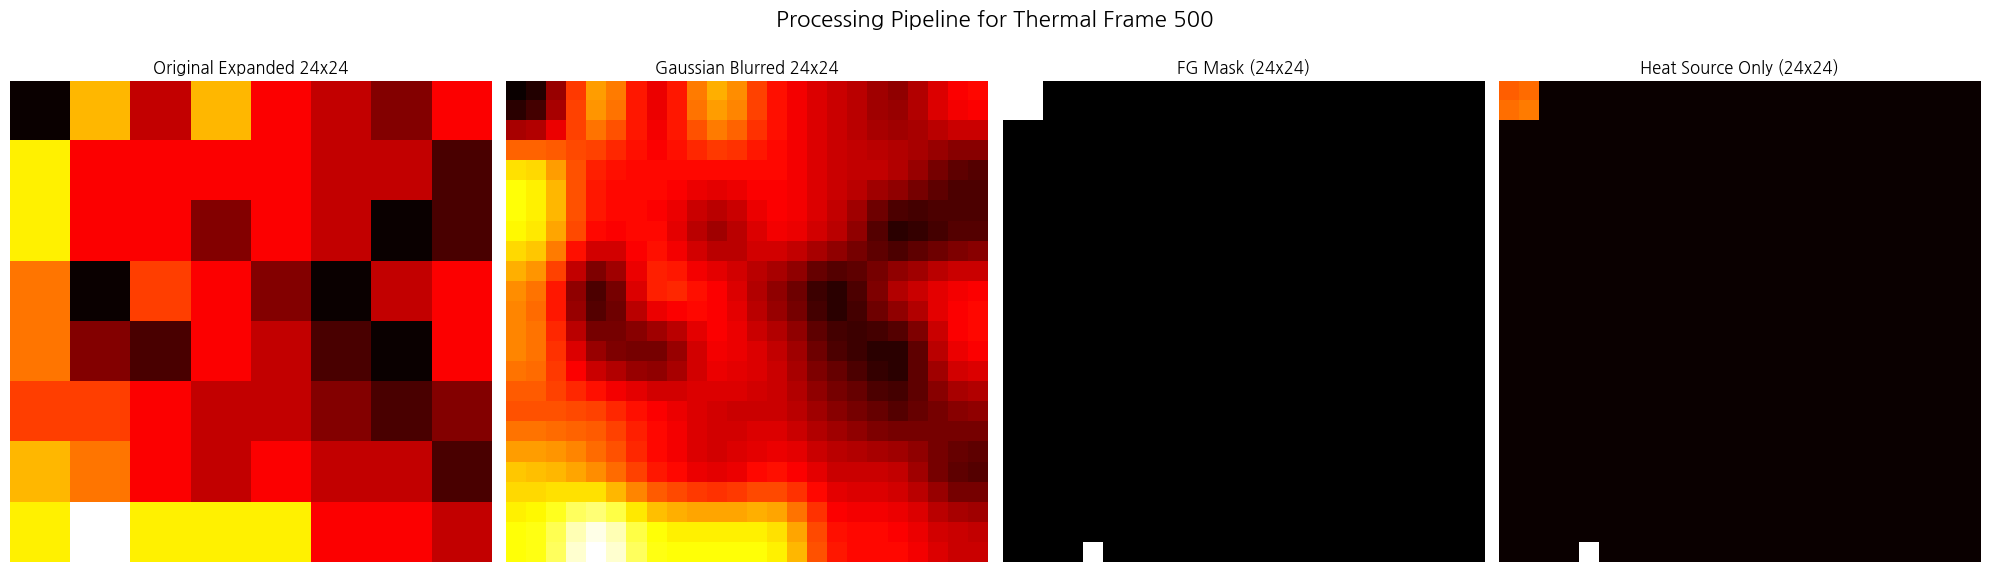

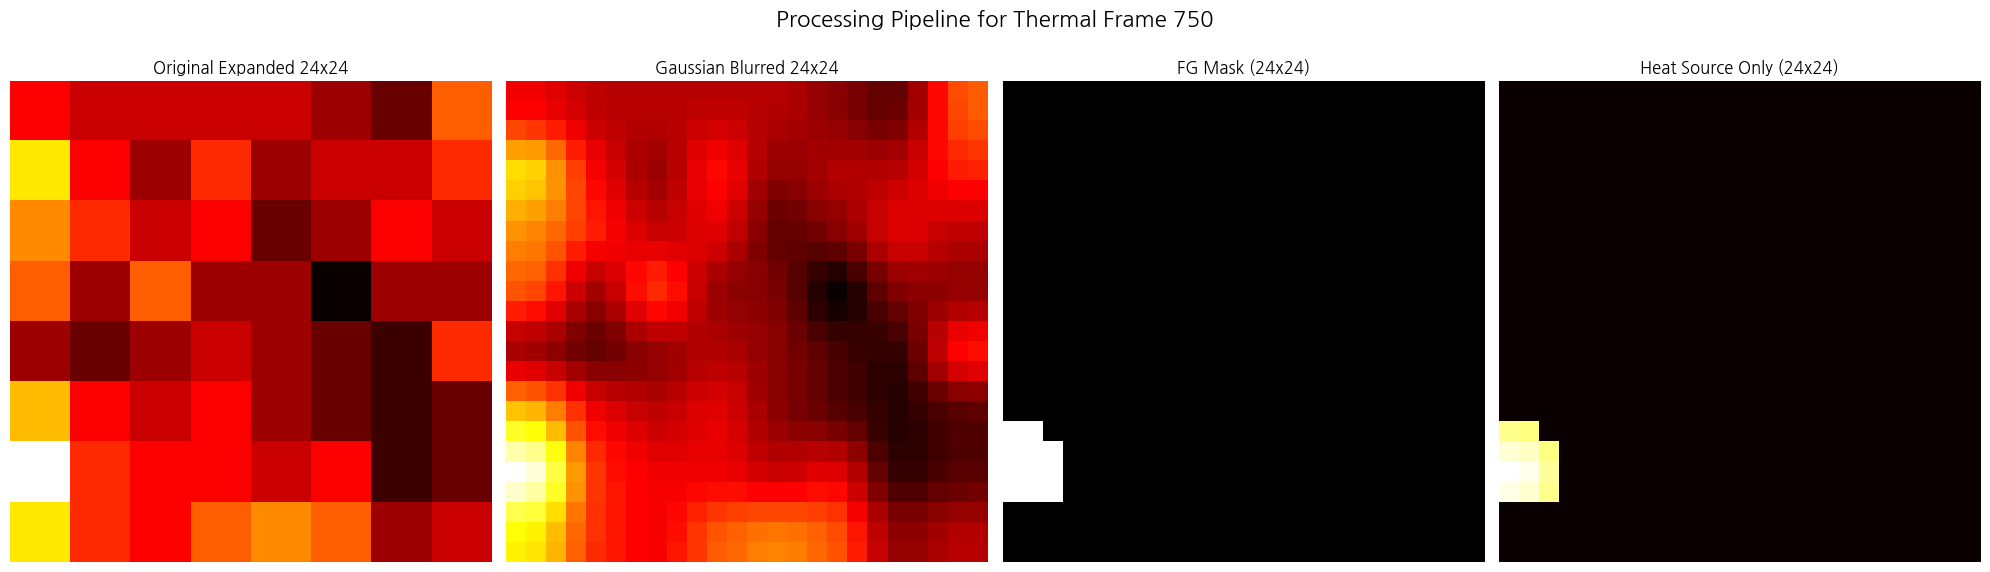

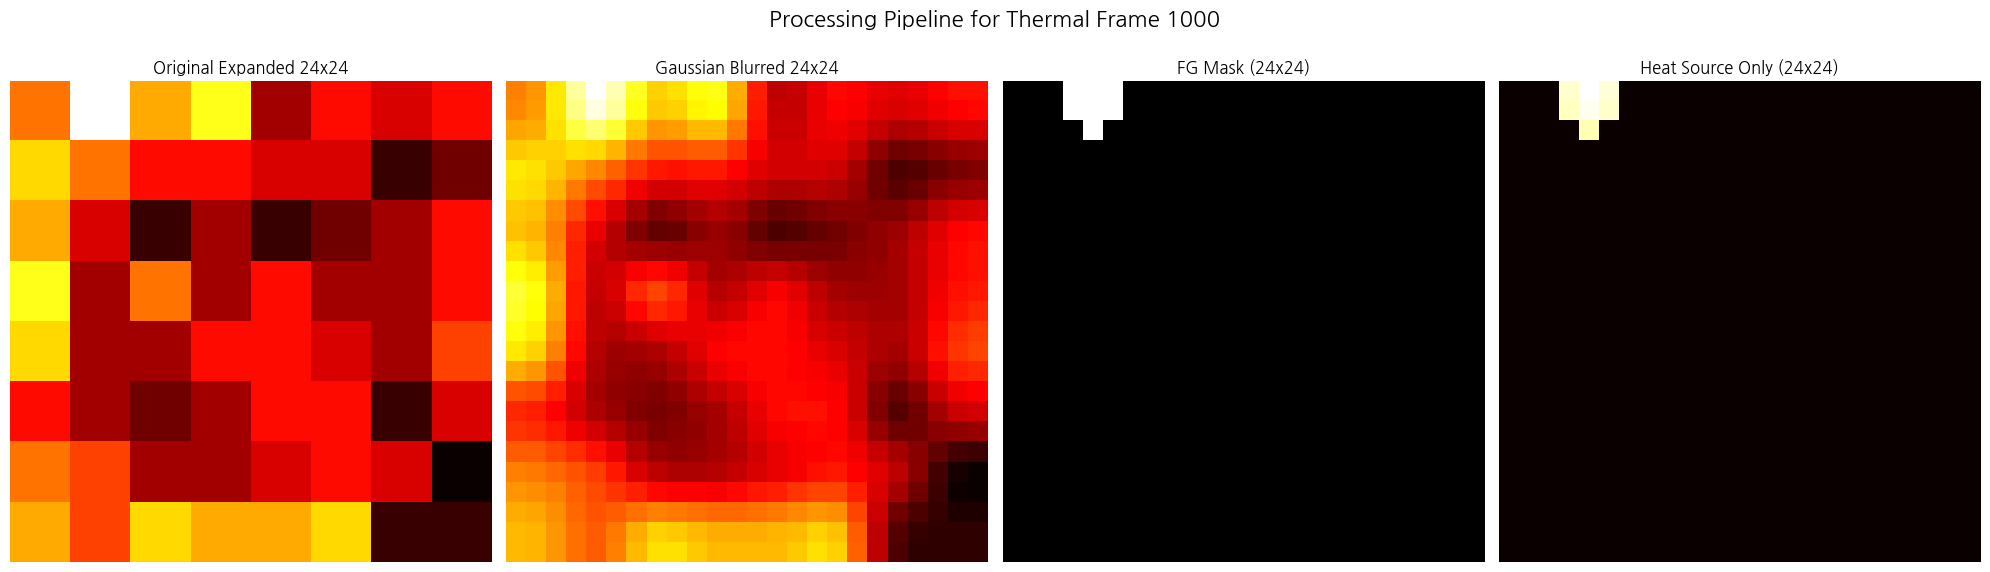

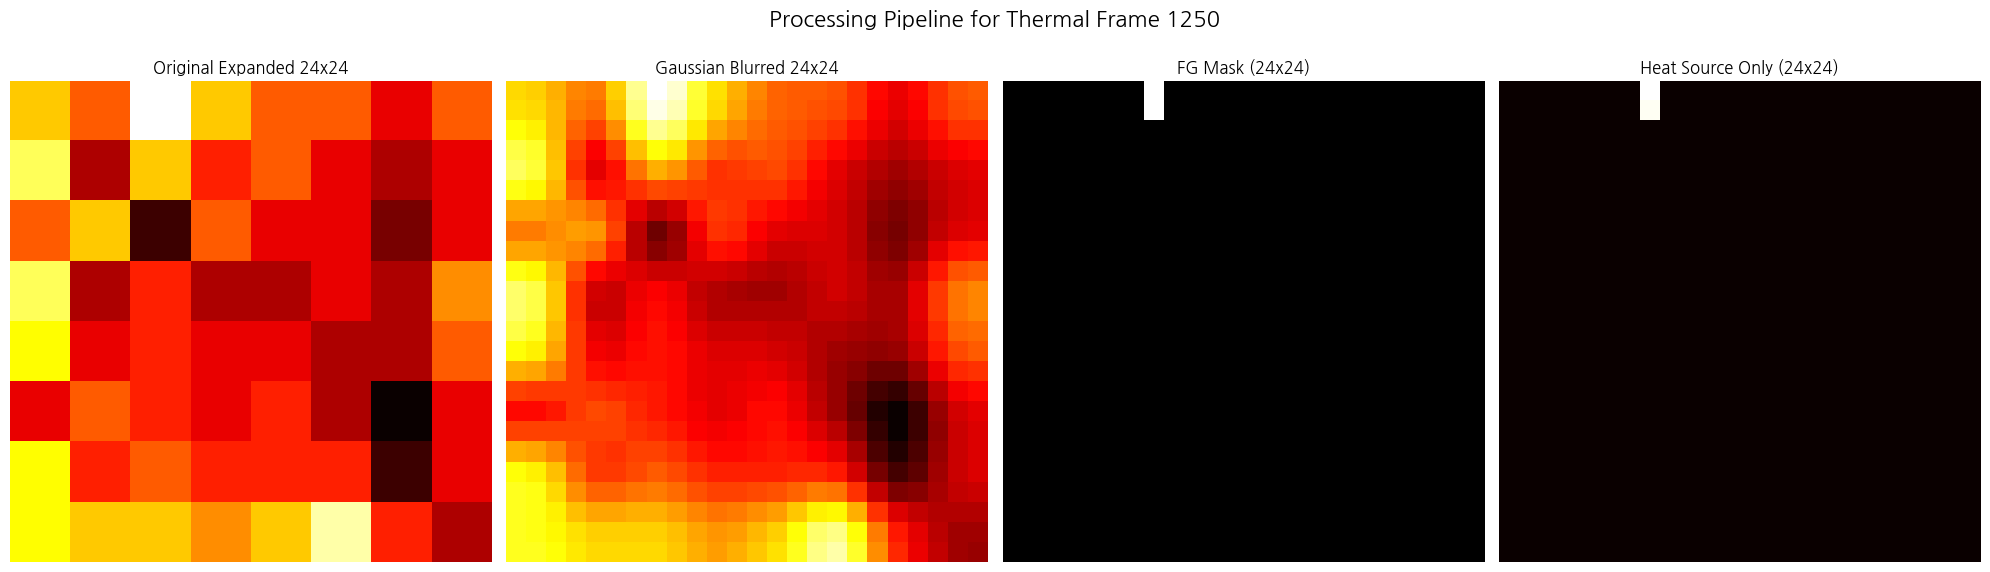

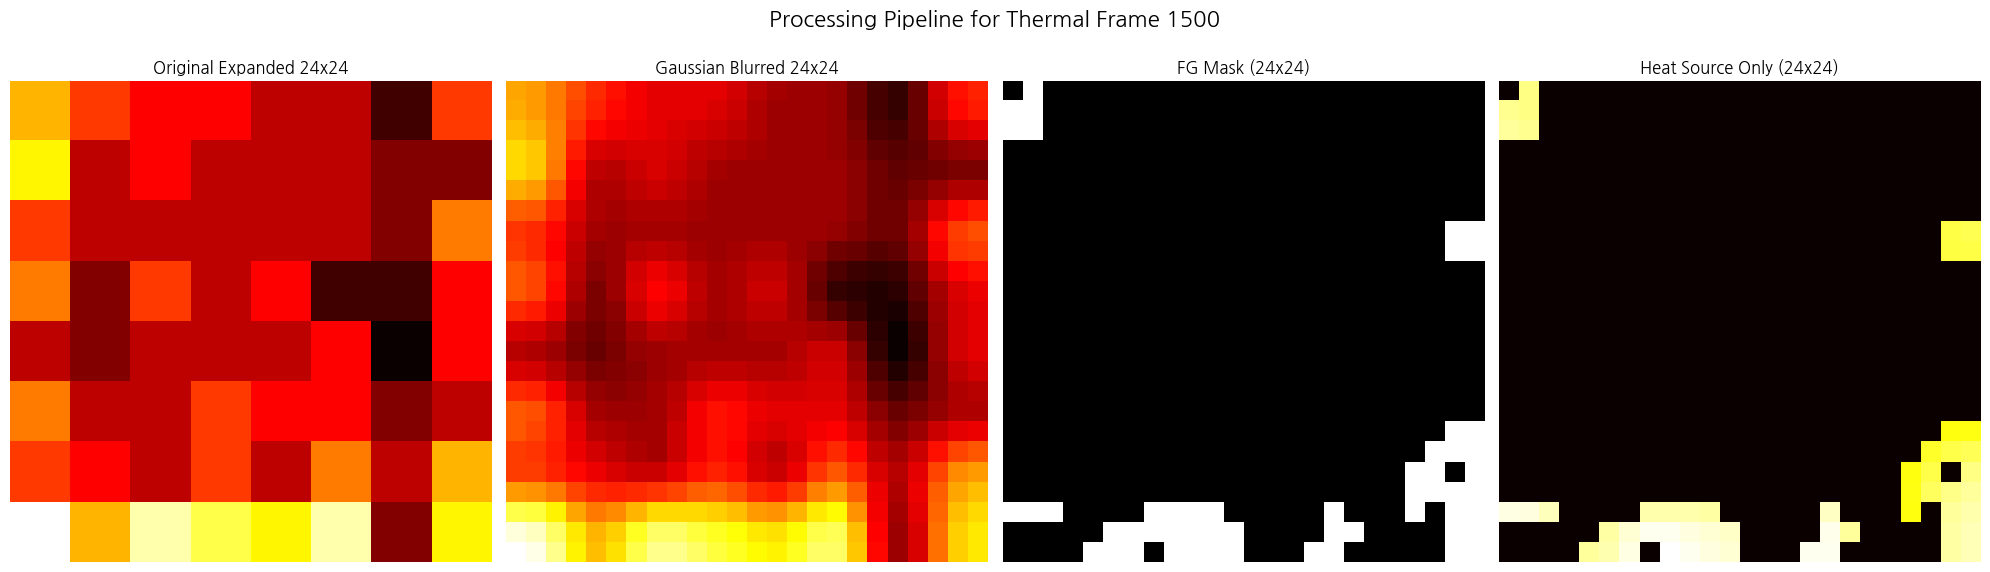

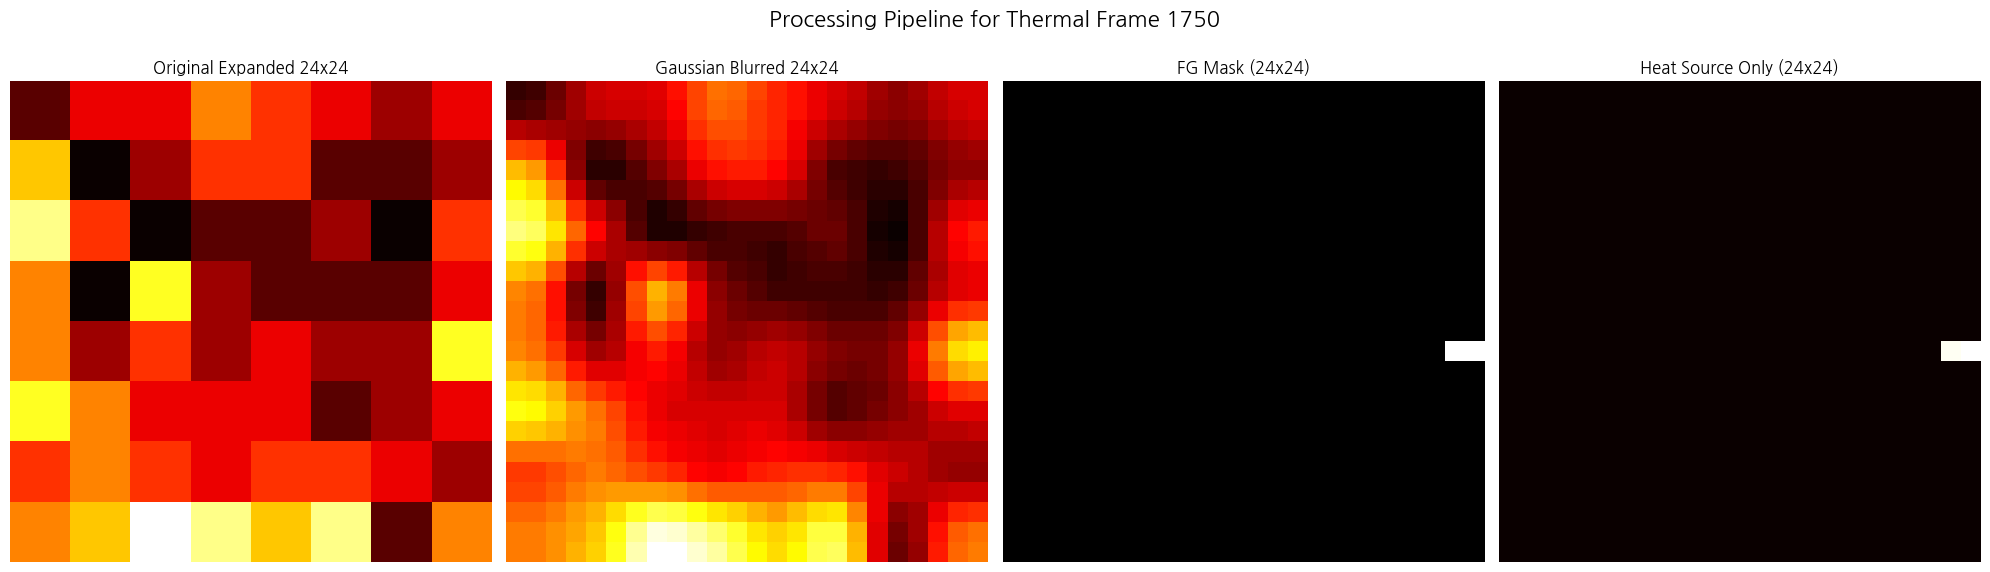

In [33]:
# --- 온도 데이터를 0-255 범위로 스케일링하는 함수 ---
def scale_temperature_to_uint8(temp_data, min_val, max_val):
    scaled_data = (temp_data - min_val) / (max_val - min_val) * 255
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

# 전체 온도 데이터의 예상 최소/최대값 계산 (스케일링을 위해 필요)
global_min_temp = min(frames_none.min().min(), frames_hu.min().min())
global_max_temp = max(frames_none.max().max(), frames_hu.max().max())
print(f"온도 데이터 전체 범위: {global_min_temp:.2f}°C ~ {global_max_temp:.2f}°C")
print("-" * 30)

# --- 1. 데이터프레임 할당 ---
frames_background = frames_none
frames_with_object = frames_hu

print(f"배경 프레임 수: {len(frames_background)}")
print(f"열원 포함 프레임 수: {len(frames_with_object)}")
print("-" * 30)

# 2. MOG2 배경 제거기 생성
fgbg = cv2.createBackgroundSubtractorMOG2(history=len(frames_background), varThreshold=12, detectShadows=False)

# --- 가우시안 필터 파라미터 ---
gaussian_ksize = (5, 5) # 커널 크기 (양의 홀수여야 함). 픽셀화된 부분을 부드럽게.
gaussian_sigmaX = 0    # 자동 계산
original_frame_width, original_frame_height = 8, 8
expanded_frame_width, expanded_frame_height = 24, 24
# 3. 배경 프레임으로 배경 모델 초기 학습 (24x24 확장 + 가우시안 필터 적용)
print("--- 배경 프레임으로 배경 모델 학습 시작 ---")
for i in range(len(frames_background.index)):
    temp_frame_2d_original = frames_background.iloc[i,:].values.reshape((original_frame_height, original_frame_width))
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, global_min_temp, global_max_temp)
    
    # 24x24로 확대 (INTER_NEAREST는 픽셀 복제)
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_frame_width, expanded_frame_height), 
                                interpolation=cv2.INTER_NEAREST)
    
    # 가우시안 필터 적용
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)

    # 필터링된 24x24 프레임을 MOG2에 입력하여 학습
    fgmask_dummy = fgbg.apply(blurred_expanded_frame) 
    
    if (i + 1) % 500 == 0:
        print(f"  {i + 1}/{len(frames_background)} 프레임 학습 완료...")
print("--- 배경 모델 학습 완료 ---")
print("-" * 30)

# 4. 객체가 있는 프레임을 넣어 전경 감지 및 추출 (24x24 확장 + 가우시안 필터 적용)
original_expanded_frames_results = [] # 24x24로 확대만 된 스케일링 원본 프레임
blurred_expanded_frames_results = [] # 24x24로 확대 및 가우시안 필터 적용된 프레임
fg_masks_results = [] # 24x24 크기 마스크
fg_only_frames_results = [] # 24x24 크기 전경

print("--- 열원 포함 프레임 처리 시작 ---")
for i in range(len(frames_with_object.index)):
    temp_frame_2d_original = frames_with_object.iloc[i,:].values.reshape((original_frame_height, original_frame_width))
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, global_min_temp, global_max_temp)
    
    # 24x24로 확대
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_frame_width, expanded_frame_height), 
                                interpolation=cv2.INTER_NEAREST)
    
    # 가우시안 필터 적용
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)

    # 필터링된 24x24 프레임을 MOG2에 입력하여 전경 감지
    fgmask = fgbg.apply(blurred_expanded_frame) 
    
    # 전경 마스크를 사용하여 필터링된 프레임에서 열원만 추출
    fg_only = cv2.bitwise_and(blurred_expanded_frame, blurred_expanded_frame, mask=fgmask)

    original_expanded_frames_results.append(expanded_frame) 
    blurred_expanded_frames_results.append(blurred_expanded_frame) 
    fg_masks_results.append(fgmask)
    fg_only_frames_results.append(fg_only)

    if (i + 1) % 200 == 0:
        print(f"  {i + 1}/{len(frames_with_object)} 프레임 처리 완료...")
print("--- 열원 포함 프레임 처리 완료 ---")
print("-" * 30)


# 5. 결과 시각화
# 이전 display_images_temp는 사용하지 않고, display_full_pipeline을 주로 사용합니다.
def display_full_pipeline(original_expanded_img, blurred_expanded_img, fg_mask, fg_only_img, idx):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6)) # 4개 서브플롯
    fig.suptitle(f'Processing Pipeline for Thermal Frame {idx}', fontsize=16)
    
    axes[0].imshow(original_expanded_img, cmap='hot')
    axes[0].set_title(f'Original Expanded {expanded_frame_width}x{expanded_frame_height}')
    axes[0].axis('off')

    axes[1].imshow(blurred_expanded_img, cmap='hot')
    axes[1].set_title(f'Gaussian Blurred {expanded_frame_width}x{expanded_frame_height}')
    axes[1].axis('off')

    axes[2].imshow(fg_mask, cmap='gray')
    axes[2].set_title(f'FG Mask ({expanded_frame_width}x{expanded_frame_height})')
    axes[2].axis('off')

    axes[3].imshow(fg_only_img, cmap='hot')
    axes[3].set_title(f'Heat Source Only ({expanded_frame_width}x{expanded_frame_height})')
    axes[3].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 타이틀 공간 확보
    plt.show()


# 시각화할 프레임 인덱스 선택 (요청하신 대로 확장)
display_idx = [
    0,                                      
    min(500, len(frames_with_object) - 1),  
    min(750, len(frames_with_object) - 1),  
    min(1000, len(frames_with_object) - 1), 
    min(1250, len(frames_with_object) - 1), 
    min(1500, len(frames_with_object) - 1), 
    min(1750, len(frames_with_object) - 1), 
]

# 각 인덱스에 대해 파이프라인 시각화
for idx in display_idx:
    display_full_pipeline(
        original_expanded_frames_results[idx],
        blurred_expanded_frames_results[idx],
        fg_masks_results[idx],
        fg_only_frames_results[idx],
        idx
    )

# 6. 마스크 후처리 (선택 사항)
post_process_idx = min(100, len(fg_masks_results) - 1) 
fgmask_example = fg_masks_results[post_process_idx]
# 후처리 시 원본으로 사용할 프레임은 이제 original_expanded_frames_results에서 가져옵니다.
original_expanded_frame_for_post = original_expanded_frames_results[post_process_idx] 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

dilated_mask = cv2.dilate(fgmask_example, kernel, iterations=1)
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

# 후처리된 마스크를 필터링된 24x24 프레임에 적용하여 전경 추출
# 만약 마스크를 원본 스케일링된 24x24 프레임에 적용하고 싶다면 original_expanded_frame_for_post를 사용
fg_only_processed = cv2.bitwise_and(blurred_expanded_frames_results[post_process_idx], blurred_expanded_frames_results[post_process_idx], mask=eroded_mask)




In [ ]:
# %pip install koreanize_matplotlib
import koreanize_matplotlib

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from datetime import datetime
import os

# --- 온도 데이터를 0-255 범위로 스케일링하는 함수 ---
def scale_temperature_to_uint8(temp_data, min_val, max_val):
    scaled_data = (temp_data - min_val) / (max_val - min_val) * 255
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

# --- 열원 존재 여부 판단 함수 ---
def detect_heat_source(fg_mask, fg_only_img, min_area_threshold=10, min_intensity_threshold=50):
    """
    열원 존재 여부를 판단하는 함수
    
    Args:
        fg_mask: 전경 마스크
        fg_only_img: 열원만 추출된 이미지
        min_area_threshold: 최소 영역 크기 (픽셀 수)
        min_intensity_threshold: 최소 강도 임계값
    
    Returns:
        dict: 열원 감지 결과 정보
    """
    # 전경 픽셀 수 계산
    foreground_pixels = np.sum(fg_mask > 0)
    total_pixels = fg_mask.size
    foreground_percentage = (foreground_pixels / total_pixels) * 100
    
    # 열원 영역의 평균 강도
    heat_intensity = 0
    if foreground_pixels > 0:
        heat_intensity = np.mean(fg_only_img[fg_mask > 0])
    
    # 연결된 구성 요소 분석
    num_labels, labels = cv2.connectedComponents(fg_mask)
    significant_components = 0
    
    for i in range(1, num_labels):  # 0은 배경이므로 제외
        component_size = np.sum(labels == i)
        if component_size >= min_area_threshold:
            significant_components += 1
    
    # 열원 존재 여부 판단
    heat_source_detected = (
        foreground_pixels >= min_area_threshold and 
        heat_intensity >= min_intensity_threshold and
        significant_components > 0
    )
    
    # 열원 강도 분류
    if heat_intensity >= 200:
        intensity_level = "매우 높음"
    elif heat_intensity >= 150:
        intensity_level = "높음"
    elif heat_intensity >= 100:
        intensity_level = "보통"
    elif heat_intensity >= 50:
        intensity_level = "낮음"
    else:
        intensity_level = "매우 낮음"
    
    return {
        'detected': heat_source_detected,
        'foreground_pixels': foreground_pixels,
        'foreground_percentage': foreground_percentage,
        'heat_intensity': heat_intensity,
        'intensity_level': intensity_level,
        'num_components': significant_components,
        'confidence': min(100, (heat_intensity / 255) * 50 + (foreground_percentage * 2))
    }

# --- 개선된 시각화 함수 (열원 감지 결과 포함) ---
def display_full_pipeline_with_detection(original_expanded_img, blurred_expanded_img, fg_mask, fg_only_img, idx, min_temp, max_temp):
    """열원 감지 결과가 포함된 파이프라인 시각화"""
    
    # 열원 감지 결과
    detection_result = detect_heat_source(fg_mask, fg_only_img)
    
    # 현재 프레임의 온도 통계 계산
    current_max_temp = min_temp + (original_expanded_img.max() / 255) * (max_temp - min_temp)
    current_avg_temp = min_temp + (original_expanded_img.mean() / 255) * (max_temp - min_temp)
    
    # 열원 감지 상태 텍스트
    status_text = "🔥 열원 감지됨" if detection_result['detected'] else "❄️ 열원 없음"
    status_color = 'red' if detection_result['detected'] else 'blue'
    
    # 메인 플롯 생성
    fig = plt.figure(figsize=(24, 10))
    
    # 그리드 레이아웃 설정
    gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 1, 1, 0.4], height_ratios=[0.15, 1, 0.05])
    
    # 상태 표시 영역
    status_ax = fig.add_subplot(gs[0, :4])
    status_ax.text(0.5, 0.5, f'{status_text}\n신뢰도: {detection_result["confidence"]:.1f}% | 강도: {detection_result["intensity_level"]}', 
                   ha='center', va='center', fontsize=20, fontweight='bold', 
                   color=status_color, transform=status_ax.transAxes)
    status_ax.axis('off')
    
    # 메인 이미지들
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[1, 2])
    ax4 = fig.add_subplot(gs[1, 3])
    ax_meter = fig.add_subplot(gs[1, 4])
    
    # 색상바용 축
    cbar_ax = fig.add_subplot(gs[2, :4])
    
    fig.suptitle(f'열원 감지 시스템 - Frame {idx}\nMax: {current_max_temp:.1f}°C, Avg: {current_avg_temp:.1f}°C', 
                 fontsize=16, fontweight='bold')
    
    # 1. 원본 확대 이미지
    im1 = ax1.imshow(original_expanded_img, cmap='hot', vmin=0, vmax=255)
    ax1.set_title(f'원본 확대\n{original_expanded_img.shape[1]}x{original_expanded_img.shape[0]}', fontweight='bold')
    ax1.axis('off')
    
    # 2. 가우시안 블러 이미지
    im2 = ax2.imshow(blurred_expanded_img, cmap='hot', vmin=0, vmax=255)
    ax2.set_title(f'가우시안 블러\n{blurred_expanded_img.shape[1]}x{blurred_expanded_img.shape[0]}', fontweight='bold')
    ax2.axis('off')
    
    # 3. 전경 마스크 (열원 감지 결과 표시)
    im3 = ax3.imshow(fg_mask, cmap='gray', vmin=0, vmax=255)
    detection_text = f'감지됨 ({detection_result["foreground_percentage"]:.1f}%)' if detection_result['detected'] else '감지 안됨'
    ax3.set_title(f'전경 마스크\n{detection_text}', fontweight='bold', 
                  color='red' if detection_result['detected'] else 'blue')
    ax3.axis('off')
    
    # 4. 열원만 추출
    im4 = ax4.imshow(fg_only_img, cmap='hot', vmin=0, vmax=255)
    ax4.set_title(f'열원 추출\n구성요소: {detection_result["num_components"]}개', fontweight='bold')
    ax4.axis('off')
    
    # 온도 미터기
    temp_range = np.linspace(0, 1, 100).reshape(-1, 1)
    im_meter = ax_meter.imshow(temp_range, cmap='hot', aspect='auto', extent=[0, 1, min_temp, max_temp])
    
    # 현재 온도 표시선
    ax_meter.axhline(y=current_max_temp, color='white', linewidth=3, linestyle='-')
    ax_meter.axhline(y=current_avg_temp, color='yellow', linewidth=2, linestyle='--')
    
    # 온도 텍스트
    ax_meter.text(1.1, current_max_temp, f'Max\n{current_max_temp:.1f}°C', 
                  va='center', ha='left', color='white', fontweight='bold', fontsize=10)
    ax_meter.text(1.1, current_avg_temp, f'Avg\n{current_avg_temp:.1f}°C', 
                  va='center', ha='left', color='yellow', fontweight='bold', fontsize=10)
    
    # 열원 감지 정보 추가
    info_text = f'픽셀수: {detection_result["foreground_pixels"]}\n강도: {detection_result["heat_intensity"]:.1f}\n신뢰도: {detection_result["confidence"]:.1f}%'
    ax_meter.text(1.1, min_temp + (max_temp - min_temp) * 0.2, info_text, 
                  va='bottom', ha='left', fontsize=8, 
                  bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.7))
    
    ax_meter.set_xlim(0, 1)
    ax_meter.set_ylim(min_temp, max_temp)
    ax_meter.set_xticks([])
    ax_meter.set_ylabel('Temperature (°C)', fontweight='bold')
    ax_meter.set_title('온도계\n& 감지정보', fontweight='bold', fontsize=12)
    
    # 색상바
    temp_labels = np.linspace(min_temp, max_temp, 11)
    cbar = plt.colorbar(im1, cax=cbar_ax, orientation='horizontal', 
                       ticks=np.linspace(0, 255, 11))
    cbar.set_ticklabels([f'{temp:.1f}°C' for temp in temp_labels])
    cbar.set_label('Temperature Scale', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    return fig, detection_result

# --- CSV 저장 함수 (열원 감지 결과 포함) ---
def save_processing_results_with_detection(original_frames, blurred_frames, fg_masks, fg_only_frames, 
                                         min_temp, max_temp, output_dir="thermal_processing_results"):
    """열원 감지 결과가 포함된 처리 결과를 CSV로 저장"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 열원 감지 결과 저장
    detection_results = []
    summary_data = []
    
    for i in range(len(original_frames)):
        # 열원 감지 수행
        detection_result = detect_heat_source(fg_masks[i], fg_only_frames[i])
        detection_results.append(detection_result)
        
        # 온도 계산
        original_temp = min_temp + (original_frames[i] / 255) * (max_temp - min_temp)
        blurred_temp = min_temp + (blurred_frames[i] / 255) * (max_temp - min_temp)
        fg_only_temp = min_temp + (fg_only_frames[i] / 255) * (max_temp - min_temp)
        
        summary_data.append({
            'frame_id': i,
            'heat_source_detected': detection_result['detected'],
            'detection_confidence': detection_result['confidence'],
            'heat_intensity_level': detection_result['intensity_level'],
            'foreground_pixels': detection_result['foreground_pixels'],
            'foreground_percentage': detection_result['foreground_percentage'],
            'heat_intensity': detection_result['heat_intensity'],
            'num_components': detection_result['num_components'],
            'original_max_temp': original_temp.max(),
            'original_avg_temp': original_temp.mean(),
            'original_min_temp': original_temp.min(),
            'blurred_max_temp': blurred_temp.max(),
            'blurred_avg_temp': blurred_temp.mean(),
            'blurred_min_temp': blurred_temp.min(),
            'fg_only_max_temp': fg_only_temp.max(),
            'fg_only_avg_temp': fg_only_temp.mean(),
            'fg_only_min_temp': fg_only_temp.min(),
        })
    
    # 상세 감지 결과 저장
    detection_df = pd.DataFrame(detection_results)
    detection_file = os.path.join(output_dir, f"heat_detection_results_{timestamp}.csv")
    detection_df.to_csv(detection_file, index_label='frame_id')
    
    # 요약 통계 저장
    summary_df = pd.DataFrame(summary_data)
    summary_file = os.path.join(output_dir, f"processing_summary_with_detection_{timestamp}.csv")
    summary_df.to_csv(summary_file, index=False)
    
    # 전체 통계 출력
    total_frames = len(summary_data)
    detected_frames = sum(1 for result in detection_results if result['detected'])
    detection_rate = (detected_frames / total_frames) * 100
    
    print(f"\n=== 열원 감지 결과 통계 ===")
    print(f"총 프레임 수: {total_frames}")
    print(f"열원 감지된 프레임: {detected_frames}")
    print(f"열원 감지 없는 프레임: {total_frames - detected_frames}")
    print(f"열원 감지율: {detection_rate:.1f}%")
    
    # 강도별 분포
    intensity_counts = {}
    for result in detection_results:
        level = result['intensity_level']
        intensity_counts[level] = intensity_counts.get(level, 0) + 1
    
    print(f"\n=== 열원 강도별 분포 ===")
    for level, count in intensity_counts.items():
        percentage = (count / total_frames) * 100
        print(f"{level}: {count}프레임 ({percentage:.1f}%)")
    
    print(f"\n감지 결과가 저장되었습니다:")
    print(f"  - 열원 감지 결과: {detection_file}")
    print(f"  - 요약 통계: {summary_file}")
    
    return {
        'detection': detection_file,
        'summary': summary_file,
        'stats': {
            'total_frames': total_frames,
            'detected_frames': detected_frames,
            'detection_rate': detection_rate,
            'intensity_distribution': intensity_counts
        }
    }

# --- 실시간 감지 상태 출력 함수 ---
def print_detection_status(frame_idx, detection_result, max_temp, avg_temp):
    """각 프레임의 열원 감지 상태를 실시간으로 출력"""
    status = "🔥 감지됨" if detection_result['detected'] else "❄️ 없음"
    
    print(f"프레임 {frame_idx:4d}: {status} | "
          f"신뢰도: {detection_result['confidence']:5.1f}% | "
          f"강도: {detection_result['intensity_level']:8s} | "
          f"최고온도: {max_temp:5.1f}°C | "
          f"평균온도: {avg_temp:5.1f}°C")

# 기존 코드의 처리 부분을 다음과 같이 수정:

# 4. 객체가 있는 프레임을 넣어 전경 감지 및 추출 (개선된 버전)
original_expanded_frames_results = []
blurred_expanded_frames_results = []
fg_masks_results = []
fg_only_frames_results = []
detection_results_list = []

print("--- 열원 포함 프레임 처리 및 감지 시작 ---")
print("프레임    상태    신뢰도    강도      최고온도   평균온도")
print("-" * 65)

for i in range(len(frames_with_object.index)):
    temp_frame_2d_original = frames_with_object.iloc[i,:].values.reshape((original_frame_height, original_frame_width))
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, global_min_temp, global_max_temp)
    
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_frame_width, expanded_frame_height), 
                                interpolation=cv2.INTER_NEAREST)
    
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)
    fgmask = fgbg.apply(blurred_expanded_frame) 
    fg_only = cv2.bitwise_and(blurred_expanded_frame, blurred_expanded_frame, mask=fgmask)

    # 열원 감지 수행
    detection_result = detect_heat_source(fgmask, fg_only)
    
    # 온도 계산
    current_max_temp = global_min_temp + (expanded_frame.max() / 255) * (global_max_temp - global_min_temp)
    current_avg_temp = global_min_temp + (expanded_frame.mean() / 255) * (global_max_temp - global_min_temp)
    
    # 실시간 상태 출력 (100프레임마다)
    if (i + 1) % 100 == 0 or detection_result['detected']:
        print_detection_status(i, detection_result, current_max_temp, current_avg_temp)

    original_expanded_frames_results.append(expanded_frame) 
    blurred_expanded_frames_results.append(blurred_expanded_frame) 
    fg_masks_results.append(fgmask)
    fg_only_frames_results.append(fg_only)
    detection_results_list.append(detection_result)

print("--- 열원 포함 프레임 처리 완료 ---")

# 개선된 CSV 저장 (열원 감지 결과 포함)
csv_files = save_processing_results_with_detection(
    original_expanded_frames_results, 
    blurred_expanded_frames_results, 
    fg_masks_results, 
    fg_only_frames_results,
    global_min_temp, 
    global_max_temp
)

# 5. 개선된 시각화 (열원 감지 결과 포함)
display_idx = [
    0,                                      
    min(500, len(frames_with_object) - 1),  
    min(750, len(frames_with_object) - 1),  
    min(1000, len(frames_with_object) - 1), 
    min(1250, len(frames_with_object) - 1), 
    min(1500, len(frames_with_object) - 1), 
    min(1750, len(frames_with_object) - 1), 
]

print("\n--- 결과 시각화 (열원 감지 결과 포함) ---")
for idx in display_idx:
    fig, detection_result = display_full_pipeline_with_detection(
        original_expanded_frames_results[idx],
        blurred_expanded_frames_results[idx],
        fg_masks_results[idx],
        fg_only_frames_results[idx],
        idx,
        global_min_temp,
        global_max_temp
    )
    
    # 콘솔에 감지 결과 출력
    print(f"\n프레임 {idx} 감지 결과:")
    print(f"  열원 감지: {'예' if detection_result['detected'] else '아니오'}")
    print(f"  신뢰도: {detection_result['confidence']:.1f}%")
    print(f"  강도 레벨: {detection_result['intensity_level']}")
    print(f"  전경 픽셀: {detection_result['foreground_pixels']}개 ({detection_result['foreground_percentage']:.1f}%)")
    print(f"  구성 요소: {detection_result['num_components']}개")
    
    # 시각화 결과 저장
    # output_dir = "thermal_processing_results"
    # if not os.path.exists(output_dir):
    #     os.makedirs(output_dir)
    
    # plot_filename = os.path.join(output_dir, f"thermal_detection_frame_{idx}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    # fig.savefig(plot_filename, dpi=300, bbox_inches='tight')
    # print(f"  시각화 저장: {plot_filename}")
    
    plt.show()

print(f"\n=== 처리 완료 ===")
print(f"모든 결과가 '{output_dir}' 폴더에 저장되었습니다.")
print(f"총 {len(frames_with_object)} 프레임이 처리되었습니다.")
print(f"열원 감지율: {csv_files['stats']['detection_rate']:.1f}%")

온도 데이터 전체 범위: 20.50°C ~ 29.00°C
=== 열원 감지 시스템 시작 ===
--- 배경 모델 학습 시작 ---
학습 프레임 수: 4073
  500/4073 프레임 학습 완료...
  1000/4073 프레임 학습 완료...
  1500/4073 프레임 학습 완료...
  2000/4073 프레임 학습 완료...
  2500/4073 프레임 학습 완료...
  3000/4073 프레임 학습 완료...
  3500/4073 프레임 학습 완료...
  4000/4073 프레임 학습 완료...
--- 배경 모델 학습 완료 ---

--- 열원 포함 프레임 처리 시작 ---
프레임    5: 🔥 감지됨 | 신뢰도:  50.4% | 강도: 낮음       | 최고온도:  25.8°C
프레임    6: 🔥 감지됨 | 신뢰도:  30.5% | 강도: 보통       | 최고온도:  26.2°C
프레임    7: 🔥 감지됨 | 신뢰도:  32.9% | 강도: 보통       | 최고온도:  26.0°C
프레임    9: 🔥 감지됨 | 신뢰도:  38.7% | 강도: 높음       | 최고온도:  27.2°C
프레임   10: 🔥 감지됨 | 신뢰도:  36.5% | 강도: 보통       | 최고온도:  26.0°C
프레임   11: 🔥 감지됨 | 신뢰도:  34.8% | 강도: 보통       | 최고온도:  26.8°C
프레임   12: 🔥 감지됨 | 신뢰도:  37.8% | 강도: 높음       | 최고온도:  27.0°C
프레임   14: 🔥 감지됨 | 신뢰도:  31.3% | 강도: 보통       | 최고온도:  26.0°C
프레임   15: 🔥 감지됨 | 신뢰도:  34.5% | 강도: 보통       | 최고온도:  26.8°C
프레임   17: 🔥 감지됨 | 신뢰도:  32.0% | 강도: 보통       | 최고온도:  25.8°C
프레임   23: 🔥 감지됨 | 신뢰도:  33.0% | 강도: 낮음       | 최고온도:  25.5

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6436\692439363.py:356: UserWarning: Glyph 10052 (\N{SNOWFLAKE}) missing from font(s) NanumGothic.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6436\692439363.py:356: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\envs\test310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10052 (\N{SNOWFLAKE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Administrator\anaconda3\envs\test310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


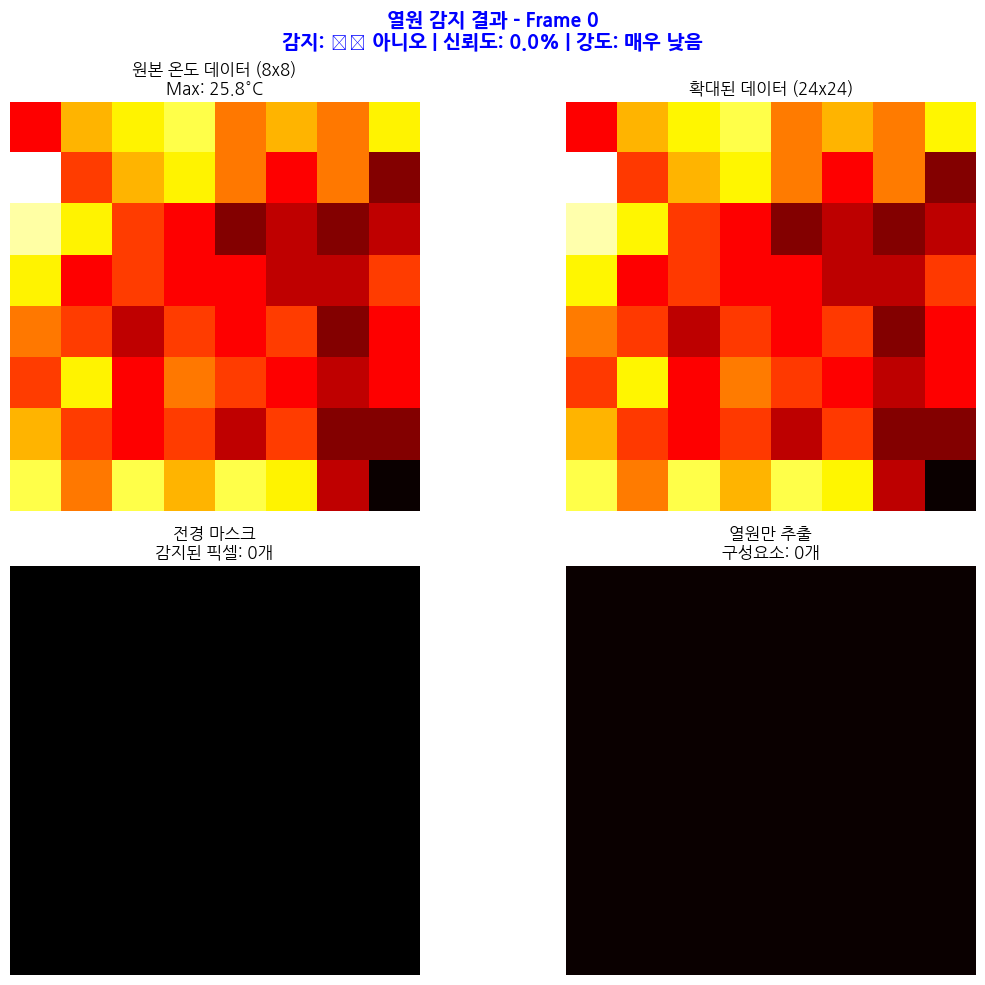


프레임 100 상세 결과:
  열원 감지: 예
  신뢰도: 86.6%
  강도 레벨: 낮음
  최고온도: 25.8°C


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6436\692439363.py:356: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) NanumGothic.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\envs\test310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


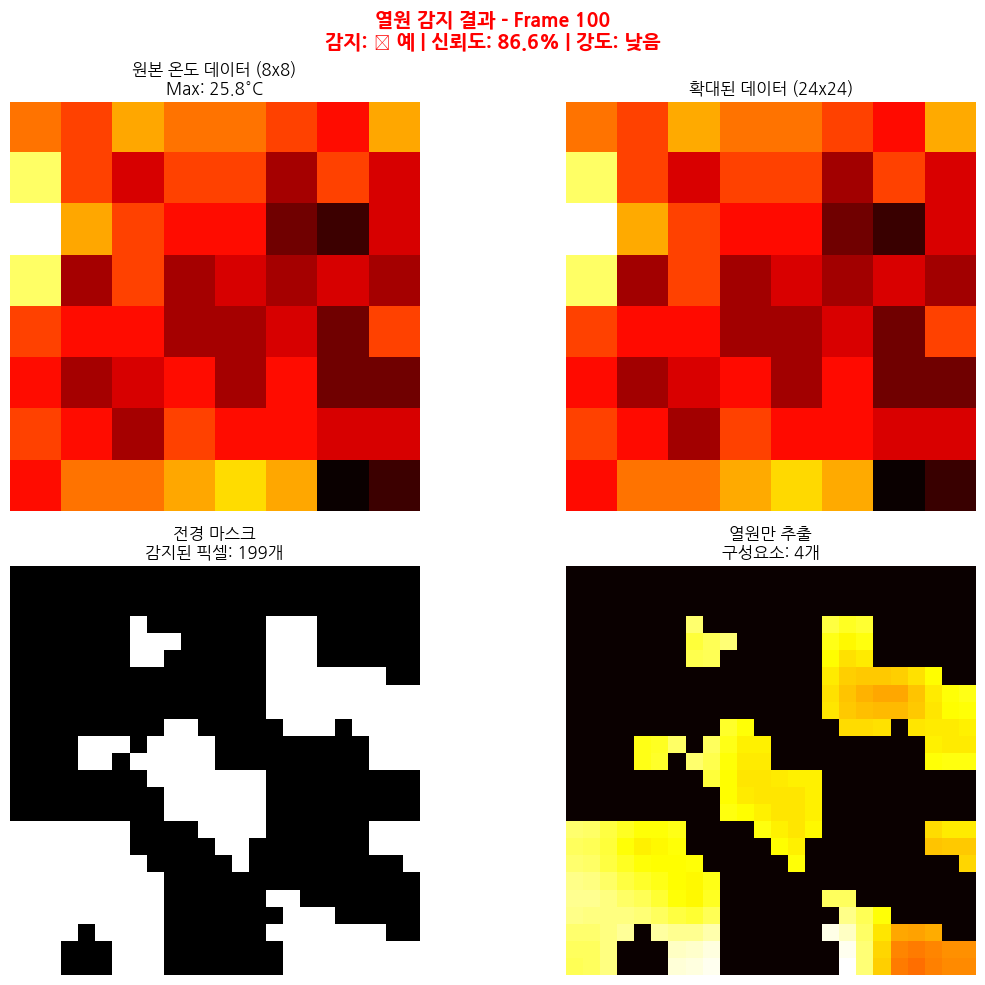


프레임 500 상세 결과:
  열원 감지: 아니오
  신뢰도: 29.6%
  강도 레벨: 보통
  최고온도: 26.0°C


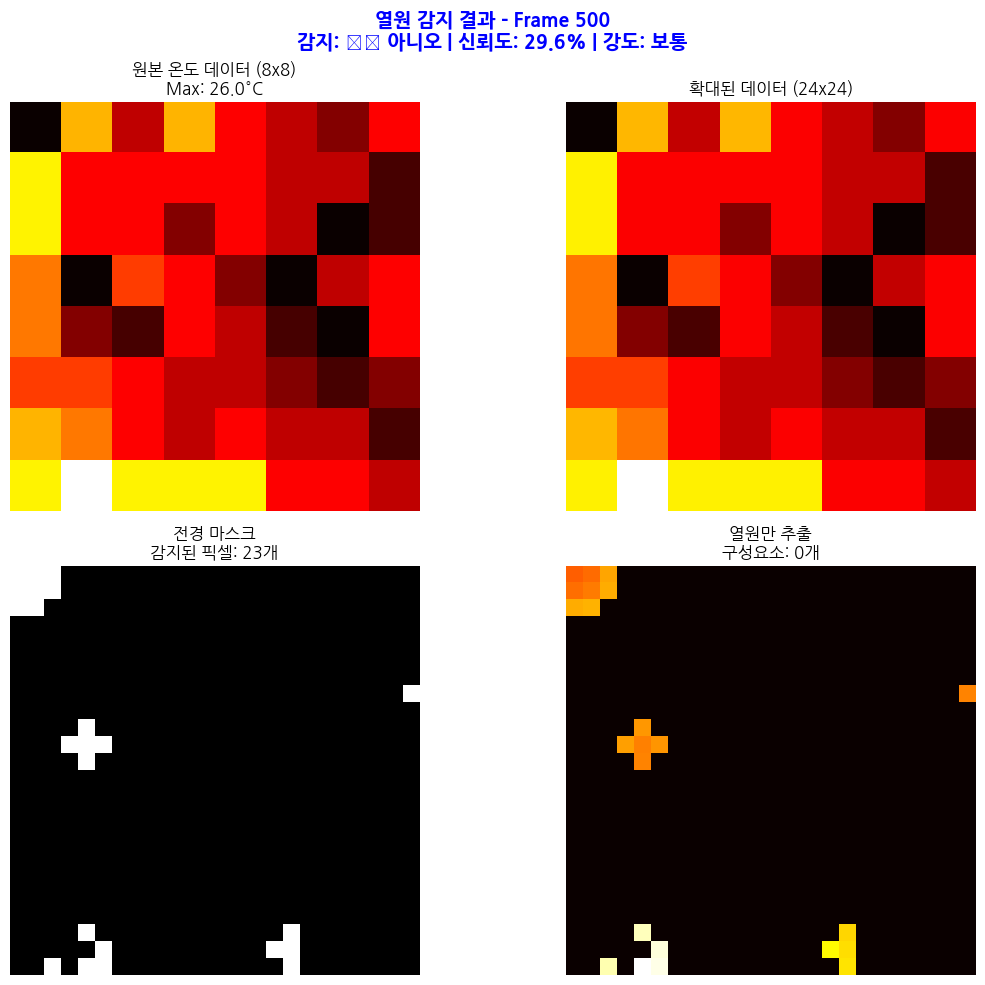


=== 최종 결과 ===
열원 감지율: 80.0%
총 처리 프레임: 2000개
저장된 파일들:
  - model_file: thermal_model_output\thermal_background_model_20250730_151903.pkl
  - heat_source_file: thermal_model_output\heat_source_only_64pixels_20250730_151903.csv
  - detection_file: thermal_model_output\heat_detection_results_20250730_151903.csv
  - training_file: thermal_model_output\background_training_data_20250730_151903.csv
